In [3]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [6]:
import torch
from sklearn.preprocessing import normalize
mfcc = torch.load('Mfcc_feature.pt')
input=[]
for m in mfcc['mfcc']:
    norm=normalize(m,axis=1)
    input.append(norm)
input=np.asarray(input).transpose(0,2,1)

In [8]:
input.shape

(20, 400, 13)

In [37]:
BUFFER_SIZE = len(input)
BATCH_SIZE = 5
steps_per_epoch = len(input)//BATCH_SIZE
embedding_dim = 10  


In [46]:
dataset = tf.data.Dataset.from_tensor_slices((input, input)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [45]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([Dimension(5), Dimension(400), Dimension(13)]),
 TensorShape([Dimension(5), Dimension(400), Dimension(13)]))

In [47]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.embedding_dim=embedding_dim
    self.lstm = tf.keras.layers.LSTM(self.embedding_dim,activation='reli',return_sequences=False,return_state=True)


  def call(self, x, hidden):
    output, state = self.lstm(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.embedding_dim))

In [48]:
encoder = Encoder(BUFFER_SIZE, embedding_dim, BATCH_SIZE)

In [49]:
sample_hidden.shape

TensorShape([Dimension(5), Dimension(1024)])

In [50]:
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (5, 400, 10)
Encoder Hidden state shape: (batch size, units) (5, 10)


In [52]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [64]:
attention_layer = BahdanauAttention(embedding_dim)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)
print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (5, 10)
Attention weights shape: (batch_size, sequence_length, 1) (5, 400, 1)


In [65]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    # self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.LSTM(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    # x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [68]:
sample_output.shape

TensorShape([Dimension(5), Dimension(400), Dimension(10)])

In [66]:
decoder = Decoder(BUFFER_SIZE, embedding_dim, embedding_dim, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

ValueError: in converted code:

    <ipython-input-65-9fe56d4e7249>:24 call
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    /home/aniset/.local/lib/python3.6/site-packages/tensorflow/python/util/dispatch.py:180 wrapper
        return target(*args, **kwargs)
    /home/aniset/.local/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py:1299 concat
        return gen_array_ops.concat_v2(values=values, axis=axis, name=name)
    /home/aniset/.local/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py:1256 concat_v2
        "ConcatV2", values=values, axis=axis, name=name)
    /home/aniset/.local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:788 _apply_op_helper
        op_def=op_def)
    /home/aniset/.local/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:507 new_func
        return func(*args, **kwargs)
    /home/aniset/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:3616 create_op
        op_def=op_def)
    /home/aniset/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:2027 __init__
        control_input_ops)
    /home/aniset/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:1867 _create_c_op
        raise ValueError(str(e))

    ValueError: Shape must be rank 3 but is rank 2 for 'decoder_2/concat' (op: 'ConcatV2') with input shapes: [5,1,10], [5,1], [].


In [13]:
X.shape

(5, 3, 2)

In [14]:
from keras.models import Model
from keras.utils import plot_model
modelEnc = Model(inputs=model.inputs, outputs=model.layers[0].output)

In [15]:
# plot_model(model, show_shapes=True, to_file='lstm_encoder.png')
# get the feature vector for the input sequence
yhat = modelEnc.predict(X[0][np.newaxis, :])
print(yhat.shape)
print(yhat)

(1, 3, 128)
[[[0.00240335 0.02035758 0.         0.         0.         0.
   0.01771674 0.         0.01970984 0.01974114 0.         0.01847213
   0.01214543 0.         0.01217868 0.01598829 0.         0.01286625
   0.01692257 0.01125239 0.         0.01832521 0.         0.
   0.         0.00334875 0.01400728 0.         0.01349204 0.
   0.         0.01057233 0.01423313 0.01080757 0.00283582 0.01211098
   0.         0.01536251 0.01046666 0.00297044 0.00696221 0.
   0.         0.01222185 0.         0.01892711 0.         0.01820657
   0.0181395  0.         0.00715906 0.         0.01075911 0.01808128
   0.02058823 0.         0.         0.         0.         0.
   0.01092621 0.         0.         0.01716203 0.01432692 0.01050153
   0.0177264  0.         0.01063289 0.01899971 0.         0.
   0.         0.00681362 0.01406739 0.         0.01439589 0.01995851
   0.         0.         0.01187121 0.         0.011489   0.
   0.         0.         0.02005072 0.         0.02130554 0.01491049
   0.    

In [16]:
X[0][np.newaxis, :].shape

(1, 3, 2)

In [17]:
import torch
mfcc = torch.load('Mfcc_feature.pt')

In [18]:
mfcc['mfcc_cmvn'][0]

array([[-3.5229154 , -3.519662  , -3.515492  , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.5437008 ,  0.57467693,  0.54538363, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.1192835 ,  0.06618722,  0.00610388, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.30640036,  0.34148166,  0.35250434, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.09921882,  0.14298284,  0.09452912, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.3792561 ,  0.34661266,  0.30345294, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [19]:
import numpy as np
input=[]
from sklearn.preprocessing import normalize
for m in mfcc['mfcc']:
    norm=normalize(m,axis=1)
    input.append(norm)

In [20]:
input=np.asarray(input).transpose(0,2,1)

In [21]:
input.shape

(20, 400, 13)

In [22]:
input.shape


(20, 400, 13)

In [23]:
input[0].shape

(400, 13)

In [31]:
timesteps = 400
n_features = 13

hist=model.fit(input, input, epochs=20, verbose=1)

Epoch 1/20
20/20 [==============================] - 2s 101ms/step - loss: 0.0025
Epoch 2/20
20/20 [==============================] - 1s 45ms/step - loss: 0.0025
Epoch 3/20
20/20 [==============================] - 1s 45ms/step - loss: 0.0025
Epoch 4/20
20/20 [==============================] - 1s 53ms/step - loss: 0.0025
Epoch 5/20
20/20 [==============================] - 1s 49ms/step - loss: 0.0025
Epoch 6/20
20/20 [==============================] - 1s 48ms/step - loss: 0.0025
Epoch 7/20
20/20 [==============================] - 1s 45ms/step - loss: 0.0025
Epoch 8/20
20/20 [==============================] - 1s 46ms/step - loss: 0.0025
Epoch 9/20
20/20 [==============================] - 1s 43ms/step - loss: 0.0025
Epoch 10/20
20/20 [==============================] - 1s 52ms/step - loss: 0.0025
Epoch 11/20
20/20 [==============================] - 1s 42ms/step - loss: 0.0025
Epoch 12/20
20/20 [==============================] - 1s 39ms/step - loss: 0.0025
Epoch 13/20
20/20 [=================

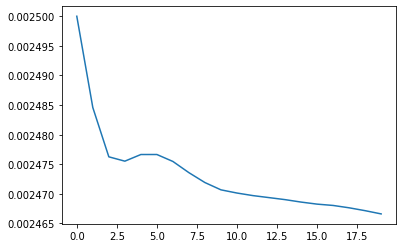

In [38]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])

In [28]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(timesteps,n_features), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(RepeatVector(timesteps))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 400, 128)          72704     
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                49408     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 400, 64)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 400, 64)           33024     
_________________________________________________________________
lstm_12 (LSTM)               (None, 400, 128)          98816     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 400, 13)           1677      
Total params: 255,629
Trainable params: 255,629
Non-trainable params: 0
________________________________________________

In [30]:
model.predict(input[0][np.newaxis, :])

array([[[-2.4423908e-35, -1.6556838e-35, -4.9496927e-35, ...,
          3.6643290e-35, -4.5738910e-35, -5.0479137e-35],
        [-5.4797253e-35, -3.8005535e-35, -1.1910777e-34, ...,
          9.0376483e-35, -1.1037622e-34, -1.2074653e-34],
        [-7.9997137e-35, -5.7861190e-35, -1.9314803e-34, ...,
          1.4873894e-34, -1.7737615e-34, -1.9491455e-34],
        ...,
        [-6.7763851e-35,  4.8068033e-36, -6.9185433e-34, ...,
          5.0410106e-34, -4.7733997e-34, -7.2474365e-34],
        [-6.7763851e-35,  4.8068033e-36, -6.9185433e-34, ...,
          5.0410106e-34, -4.7733997e-34, -7.2474365e-34],
        [-6.7763851e-35,  4.8068033e-36, -6.9185433e-34, ...,
          5.0410106e-34, -4.7733997e-34, -7.2474365e-34]]], dtype=float32)